In [2]:
import numpy as np
import wandb

In [3]:
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes()
diabetes_data = diabetes.data
y = diabetes.target
diabetes_X = diabetes_data[:,2]

In [4]:
### Modèle

class RegLin():
    def __init__(self) -> None:
        self.beta_1 = np.random.randn(1)
        self.beta_0 = np.random.randn(1)

    def __call__(self, x: float) -> float:
        return self.beta_1 * x + self.beta_0

In [5]:
### Loss function

class MSE():
    def __init__(self) -> None:
        pass

    def __call__(self, Y_pred: np.array, Y_true: np.array) -> float:
        return np.mean((Y_pred - Y_true)**2)

    def gradient(self, X: np.array,  Y_pred: np.array, Y_true: np.array) -> tuple[float, float]:
        grad_beta_0 = (2/(Y_pred.shape[0])*(np.sum(Y_pred - Y_true)))
        grad_beta_1 = (2/(Y_pred.shape[0])*np.sum((X @ (Y_pred - Y_true))))
        return grad_beta_0, grad_beta_1

In [8]:
## Hyperparameters

lr= 0.1
epochs = 100000

In [9]:
## Gradient Descent
%time

loss_history = []
model = RegLin()
mse = MSE()
early_stopping = True

for epoch in range(epochs):
  # Calculate the loss function
  current_loss = mse(model(diabetes_X), y)
  loss_history.append(current_loss)

  ## Early stopping
  if epoch > 1 and early_stopping:
    if current_loss == loss_history[-2]:
      break

  # Update parameters
  grad_beta_0, grad_beta_1 = mse.gradient(diabetes_X, model(diabetes_X), y)
  model.beta_0 -= lr*grad_beta_0
  model.beta_1 -= lr*grad_beta_1

  # Show updated variables
  if epoch % 1000 == 0 or epoch == epochs - 1:
    print("-------------------- Epoch {} --------------------".format(epoch))
    print("Current Loss: {}".format(current_loss))
    print("beta_1 = {}".format(model.beta_1))
    print("beta_0 = {}".format(model.beta_0))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs
-------------------- Epoch 0 --------------------
Current Loss: 29157.48499279051
beta_1 = [0.24816309]
beta_0 = [30.21070162]
-------------------- Epoch 1000 --------------------
Current Loss: 4715.65592365812
beta_1 = [345.77301838]
beta_0 = [152.13348416]
-------------------- Epoch 2000 --------------------
Current Loss: 4224.223469008673
beta_1 = [565.5192722]
beta_0 = [152.13348416]
-------------------- Epoch 3000 --------------------
Current Loss: 4025.4546730704637
beta_1 = [705.27308537]
beta_0 = [152.13348416]
-------------------- Epoch 4000 --------------------
Current Loss: 3945.0590177470694
beta_1 = [794.15345514]
beta_0 = [152.13348416]
-------------------- Epoch 5000 --------------------
Current Loss: 3912.541532472938
beta_1 = [850.67942714]
beta_0 = [152.13348416]
-------------------- Epoch 6000 --------------------
Current Loss: 3899.3892440277473
beta_1 = [886.62870952]
beta_0 = [152.13348416]
----------

In [10]:
class AdamOptim():
    def __init__(self, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, t, w, b, dw, db):
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw = self.beta1*self.m_dw + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw = self.beta2*self.v_dw + (1-self.beta2)*(dw**2)
        # *** biases *** #
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(-db)

        ## bias correction
        m_dw_corr = self.m_dw/(1-self.beta1**t)
        m_db_corr = self.m_db/(1-self.beta1**t)
        v_dw_corr = self.v_dw/(1-self.beta2**t)
        v_db_corr = self.v_db/(1-self.beta2**t)
        
        ## update weights and biases
        w = w - self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b - self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))
        return w, b

In [12]:
%%time
import random
epochs = 100000
batch_size = 100
steps_per_epochs = int(len(diabetes_X) / batch_size)
batch_loss_history_Adam = []
batch_loss_by_step_history_Adam = []
model = RegLin()
adam = AdamOptim()
early_stopping = True
t=1

for epoch in range(epochs):
  # Calculate epoch loss 
  current_loss = mse(model(diabetes_X), y)
  batch_loss_history_Adam.append(current_loss)
  index = random.sample(range(len(diabetes_X)), len(diabetes_X))
  for step in range(steps_per_epochs):
    # define the batch index
    index_step = index[step*batch_size:(step+1)*batch_size]
    # define  random sample :
    data_sample = diabetes_X[index_step]
    target_sample = y[index_step]

    # calculate step loss
    step_loss = mse(model(data_sample), target_sample)
    batch_loss_by_step_history_Adam.append(step_loss)

     ## Early stopping
    if epoch > 1 and early_stopping:
      if step_loss == batch_loss_by_step_history_Adam[-2]:
        break
    # Update variables
    grad_beta_0, grad_beta_1 = mse.gradient(diabetes_X, model(diabetes_X), y)
    beta_1, beta_0 = adam.update(t, w=model.beta_1, b=model.beta_0, dw=grad_beta_1, db=grad_beta_0 )
    t+=1
    model.beta_0 = beta_0
    model.beta_1 = beta_1

  # Show updated variables
  if epoch % 100 == 0 or epoch == epochs - 1:
    print("-------------------- Epoch {} --------------------".format(epoch))
    print("Current Loss: {}".format(current_loss))
    print("beta_1 = {}".format(model.beta_1))
    print("beta_0 = {}".format(model.beta_0))


-------------------- Epoch 0 --------------------
Current Loss: 29078.00648578071
beta_1 = [-0.85442409]
beta_0 = [0.69843307]
-------------------- Epoch 100 --------------------
Current Loss: 14549.963393243162
beta_1 = [3.14184999]
beta_0 = [59.70483626]
-------------------- Epoch 200 --------------------
Current Loss: 8694.07301774141
beta_1 = [7.13082218]
beta_0 = [99.5897185]
-------------------- Epoch 300 --------------------
Current Loss: 6634.699641624224
beta_1 = [11.11353529]
beta_0 = [124.90338658]
-------------------- Epoch 400 --------------------
Current Loss: 6024.626406809148
beta_1 = [15.09097642]
beta_0 = [139.63505707]
-------------------- Epoch 500 --------------------
Current Loss: 5873.400566759592
beta_1 = [19.06404356]
beta_0 = [147.24185554]
-------------------- Epoch 600 --------------------
Current Loss: 5834.778024786287
beta_1 = [23.03353162]
beta_0 = [150.57835284]
-------------------- Epoch 700 --------------------
Current Loss: 5815.8524983774205
beta_1 

In [13]:
%%time
import random
epochs = 100000
batch_size = 100
steps_per_epochs = int(len(diabetes_X) / batch_size)
batch_loss_history = []
batch_loss_by_step_history = []
model = RegLin()

early_stopping = True


for epoch in range(epochs):
  # Calculate epoch loss 
  current_loss = mse(model(diabetes_X), y)
  batch_loss_history.append(current_loss)
  index = random.sample(range(len(diabetes_X)), len(diabetes_X))
  for step in range(steps_per_epochs):
    # define the batch index
    index_step = index[step*batch_size:(step+1)*batch_size]
    # define  random sample :
    data_sample = diabetes_X[index_step]
    target_sample = y[index_step]

    # calculate step loss
    step_loss = mse(model(data_sample), target_sample)
    batch_loss_by_step_history.append(step_loss)

     ## Early stopping
    if epoch > 1 and early_stopping:
      if step_loss == batch_loss_by_step_history[-2]:
        break
    # Update variables
    grad_beta_0, grad_beta_1 = mse.gradient(diabetes_X, model(diabetes_X), y)

    model.beta_0 -= lr*grad_beta_0
    model.beta_1 -= lr*grad_beta_0

  # Show updated variables
  if epoch % 100 == 0 or epoch == epochs - 1:
    print("-------------------- Epoch {} --------------------".format(epoch))
    print("Current Loss: {}".format(current_loss))
    print("beta_1 = {}".format(model.beta_1))
    print("beta_0 = {}".format(model.beta_0))

-------------------- Epoch 0 --------------------
Current Loss: 29114.951540526785
beta_1 = [89.86957734]
beta_0 = [89.76531664]
-------------------- Epoch 100 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 200 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 300 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 400 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 500 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 600 --------------------
Current Loss: 5328.293415202175
beta_1 = [152.23774487]
beta_0 = [152.13348416]
-------------------- Epoch 700 --------------------
Current Loss: 5328.29341520

In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(epochs)], y=batch_loss_history_Adam[:20000],
              mode="markers+lines",
              name="AdamW gradient descent loss"))
fig.add_trace(go.Scatter(x=[i for i in range(epochs)], y=batch_loss_history[:20000],
              mode="markers+lines",
              name="mini batch sgd loss"))


fig.update_layout(
    title="Gradient descent vs. Adam",
    xaxis_title="epochs",
    yaxis_title="loss"
    )
fig.show()


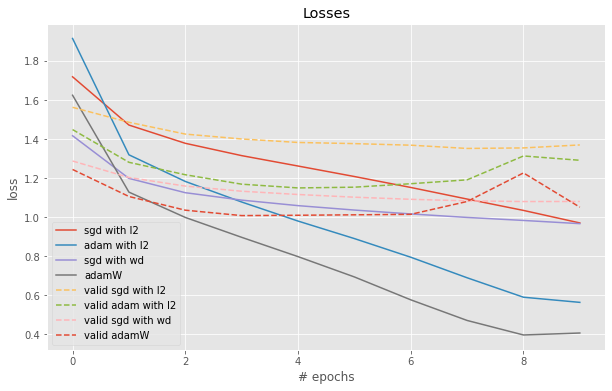